Reproduce Figure 3 of Group Invariant Scattering (Mallat, 2012)

In [6]:
#matplotlib inline

import pylab as plt

import numpy as np


In [78]:
N = 8 * 1024
Jmax = np.log2(N)

# example signals

f1 = np.zeros(N)
R = 20
P = 8*R+1
start = np.int(N/2-R)
end = np.int(N/2 + R)
f1[start:end] = 1
# w = np.zeros(R)
# w[0:P] = np.arange(0, P)
# w = (w-1)*8/P-4

A1 = np.abs(np.fft.fft(f1))
P = np.int(N/2)
z = np.zeros(P)
z[0:P] = np.arange(0,P)
z = 10*z*2*np.pi / P

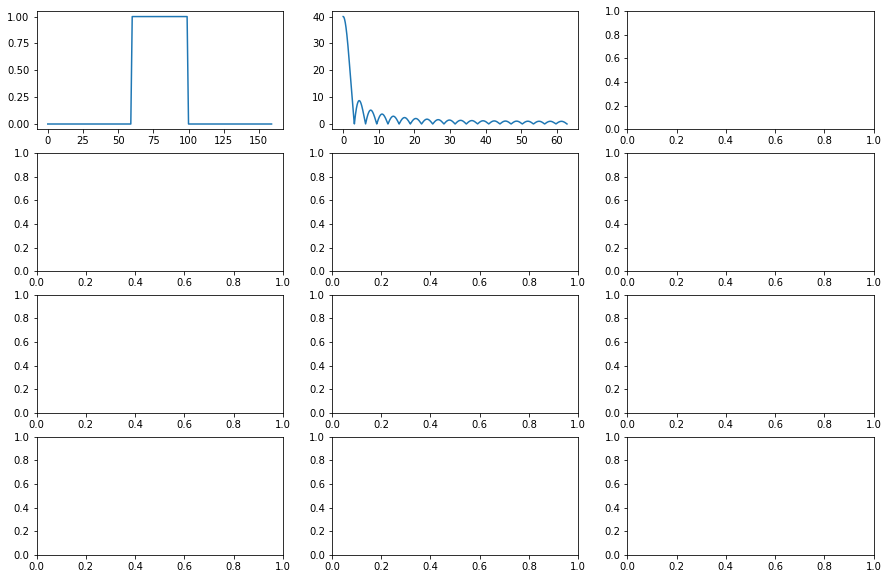

In [80]:
start_plot = np.int(N/2 - 4*R)
end_plot = np.int(N/2 + 4*R)

fig, ax = plt.subplots(4,3, figsize=(15,10))

ax[0,0].plot(f1[start_plot:end_plot])
ax[0,1].plot(z,A1[0:P])
plt.show()